# Graph Maker

Notebook for graphing 14CO Profile models and Sensitivity Calculations

In [173]:
import os

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm
from cycler import cycler

from scipy.stats import norm

from coprofile import COProfile, COGenerator
from likelihood import ModelLikelihood

import random

from time import time

In [174]:
colors = mpl.cm.viridis(np.linspace(0., 1., 5))

axes_style = { 'grid'      : 'True',
               'labelsize' : '14',
               'labelpad'  : '8.0',
               'prop_cycle': cycler('color', colors) }
grid_style = { 'alpha'     : '0.75',
               'linestyle' : ':' }
font_style = { 'size'      : '14' }

mpl.rc('font', **font_style)
mpl.rc('axes', **axes_style)
mpl.rc('grid', **grid_style)

## Load Models

Loads 14CO Profiles from FITS files in models folder.

In [175]:
fixed='past' # 14CO production rate fixed in past for variable models
#fixed='pres' # 14CO production rate fixed at present for variable models

#f_factors='const' # only constant models parameterize over f_factors
f_factors='all' # all models parameterize over f_factors

In [176]:
fmu_neg, fmu_fast = 0.066, 0.072 # baseline f-factors for the null (constant) model

In [177]:
depthavg = 20.   # in meters
relerror = 0.02 # relative error when sampling a CO Profile

const_models = ModelLikelihood('models/balco_14co_const_models.fits', depth_avg=depthavg, rel_uncertainty=relerror)
linear_models = ModelLikelihood('models/balco_14co_linear_models_{}_{}.fits'.format(fixed, f_factors),
                                depth_avg=depthavg, rel_uncertainty=relerror)
step_models = ModelLikelihood('models/balco_14co_step_models_{}_{}.fits'.format(fixed, f_factors),
                              depth_avg=depthavg, rel_uncertainty=relerror)
burst_models = ModelLikelihood('models/balco_14co_burst_models_{}.fits'.format(f_factors),
                               depth_avg=depthavg, rel_uncertainty=relerror)
    
Models = [const_models, linear_models, step_models, burst_models] # 0: const; 1: linear; 2: step; 3: burst
modelNames = ['constant', 'linear', 'step', 'burst']

## f_factors Graph

Graph of the parameter space of f_mu_neg and f_mu_fast

Text(0.5, 1.0, 'Constant Model f_factors')

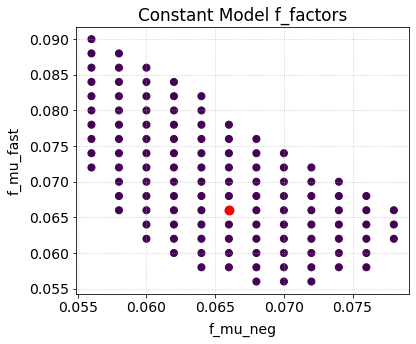

In [178]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.scatter(const_models.fofactors['FOMUNEG'],const_models.fofactors['FOMUFAST'], s=np.exp(const_models.logprior)*50)
ax.scatter(fmu_neg, fmu_neg, c='red', s=80)
ax.set(xlabel='f_mu_neg',
        ylabel='f_mu_fast')
plt.title('Constant Model f_factors')

## CO Profiles

Plots a representative selection of N CO Profiles from a given model type.

In [179]:
m = 0 #model type to plot
N = 12 #Number of realizations to plot

In [180]:
def param_dist(model, theta0, weights = [1]): # calculates distance in parameter space to theta0
    w = np.array(weights)
    theta0 = np.array(theta0)
    return np.sum(w * (model.parameters - theta0)**2, axis=1)

In [181]:
def plot_profiles(m, N=12):
    #total 14CO in each profile
    a = np.array([np.sum(p.CO) for p in Models[m].models]) 
    
    # sort profiles in descending order by total 14CO
    index = a.argsort()
    ind = index[np.linspace(len(index)-1,0,num=N, dtype=int)]
    
    # baseline constant model
    dist = param_dist(const_models, [fmu_neg, fmu_fast])
    j = dist.argmin()
    data_const = const_models.models[j]
    
    # plot
    fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
    for i in ind:
        ax.plot(Models[m].models[i].z, Models[m].models[i].CO, label='{} {}'.format(modelNames[m].title(), Models[m].parameters[i]))
    ax.plot(data_const.z, data_const.CO, ls='--', lw=2, c='red', label='Constant ({:.3f}, {:.3f})'.format(fmu_neg, fmu_fast))
    ax.set(xlim=(90,300),
            xlabel='depth [m]',
            ylim=(0,40),
            ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
    ax.legend(loc='upper left', fontsize=8)
    plt.title('{} Model CO Profiles'.format(modelNames[m].title()))

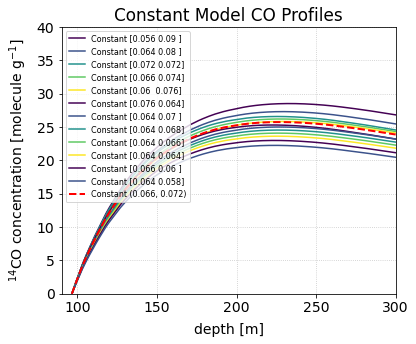

In [182]:
plot_profiles(0)

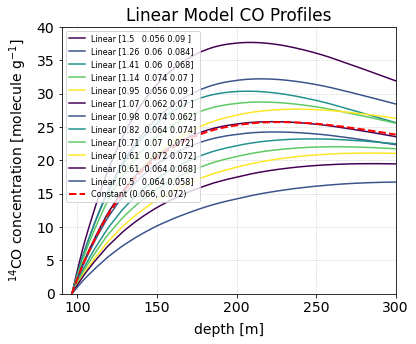

In [183]:
plot_profiles(1)

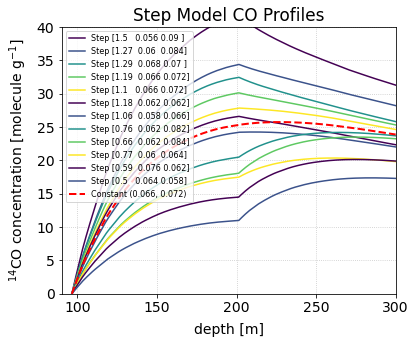

In [184]:
plot_profiles(2)

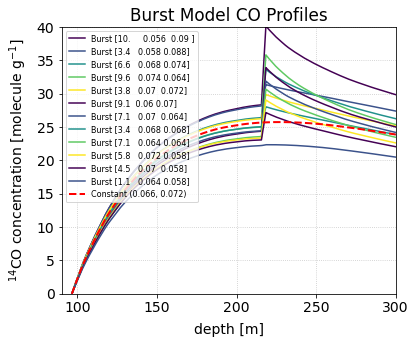

In [185]:
plot_profiles(3)

## CO Samples

Samples a CO Profile from a given model type, then calculates the Bayes factors between the Constant and Variable hypotheses

Can optionally plot the best fit to the sample from a given model.

In [186]:
def param_chi2(model, CO_samp, dCO_samp):
    return np.sum(((model.CO_mods - CO_samp)/dCO_samp)**2, axis=1)

In [187]:
def plot_model(m, theta0 = [], fit=None): # plots model# m against constant model, takes random sample, and calculates Bayes factors
    
    #baseline model
    dist = param_dist(const_models, [fmu_neg, fmu_fast])
    i = dist.argmin()
    data_const = const_models.models[i]
    
    # sampled model
    if theta0 == []: # if no parameters given, pick random parameters
        j = random.choices(np.arange(len(Models[m].models)), weights=np.exp(Models[m].logprior))[0]
        data_lin = Models[m].models[j]
    else: # find closest model to requested parameters
        dist = param_dist(Models[m], theta0)
        j = dist.argmin()
        data_lin = Models[m].models[j]
    print('params: {}'.format(Models[m].parameters[j]))
    
    z_samp, CO_samp, dCO_samp = data_lin.sample_z() # get CO sample
    
    # find best fit to sample
    if fit != None:
        fit_models = Models[fit]
        chi2 = param_chi2(fit_models, CO_samp, dCO_samp) - 2*fit_models.logprior
        i = chi2.argmin()
        const_fit = fit_models.models[i]
        print('{} fit params: {}'.format(modelNames[fit], fit_models.parameters[i]))
        print('Chi^2 fit: {}'.format(chi2[i]))
    print()

    # plot sample and models
    fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
    ax.plot(data_const.z, data_const.CO, 'r--', label='Constant model')
    ax.plot(data_lin.z, data_lin.CO, lw=2, label='{} {}'.format(modelNames[m].title(), Models[m].parameters[j]))
    if fit != None:
        ax.plot(const_fit.z, const_fit.CO, ls='--', label='{} {}'.format(modelNames[fit].title(), fit_models.parameters[i]))
    ax.errorbar(z_samp, CO_samp, yerr=dCO_samp, fmt='.', label='CO Sample')
    ax.set(xlim=(90,300),
           xlabel='depth [m]',
           ylim=(0,40),
           ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
    ax.legend(loc='lower right', fontsize=10)
    if fit != None:
        plt.title('{} CO Profile Sample w/ {} Fit'.format(modelNames[m].title(), modelNames[fit].title()))
    else:
        plt.title('{} CO Profile Sample'.format(modelNames[m].title()))

    # Try out some likelihood ratio tests.
    B01 = const_models.likelihood(z_samp, CO_samp, dCO_samp) / linear_models.likelihood(z_samp, CO_samp, dCO_samp)
    print(f'B_01 = {B01:12g}; 0=const model, 1=linear model')

    B02 = const_models.likelihood(z_samp, CO_samp, dCO_samp) / step_models.likelihood(z_samp, CO_samp, dCO_samp)
    print(f'B_02 = {B02:12g}; 0=const model, 2=step model')

    B03 = const_models.likelihood(z_samp, CO_samp, dCO_samp) / burst_models.likelihood(z_samp, CO_samp, dCO_samp)
    print(f'B_03 = {B03:12g}; 0=const model, 3=burst model')

params: [0.062 0.076]

B_01 =      9.39636; 0=const model, 1=linear model
B_02 =      10.5768; 0=const model, 2=step model
B_03 =      6.47623; 0=const model, 3=burst model


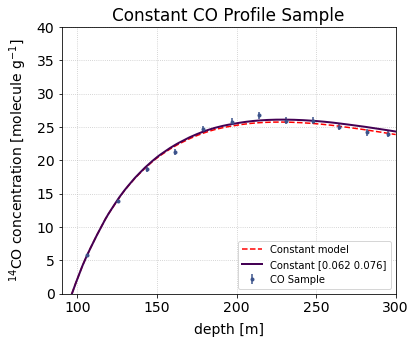

In [188]:
plot_model(0)

params: [1.12  0.062 0.076]
constant fit params: [0.062 0.084]
Chi^2 fit: 26.563356756844065

B_01 =   0.00053523; 0=const model, 1=linear model
B_02 =    0.0014438; 0=const model, 2=step model
B_03 =      26.0447; 0=const model, 3=burst model


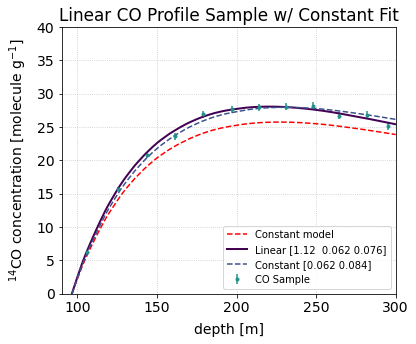

In [189]:
plot_model(1, fit=0)

params: [1.38  0.058 0.072]
constant fit params: [0.056 0.09 ]
Chi^2 fit: 538.7298276889088

B_01 =  1.0046e-111; 0=const model, 1=linear model
B_02 = 5.19088e-116; 0=const model, 2=step model
B_03 =    0.0208515; 0=const model, 3=burst model


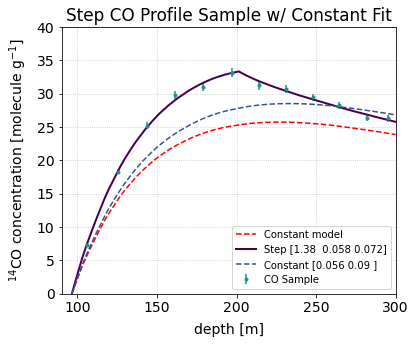

In [190]:
plot_model(2, fit=0)

params: [4.4   0.06  0.064]
constant fit params: [0.056 0.072]
Chi^2 fit: 40.233967186824906

B_01 =   0.00998617; 0=const model, 1=linear model
B_02 =   0.00132519; 0=const model, 2=step model
B_03 =  1.28986e-06; 0=const model, 3=burst model


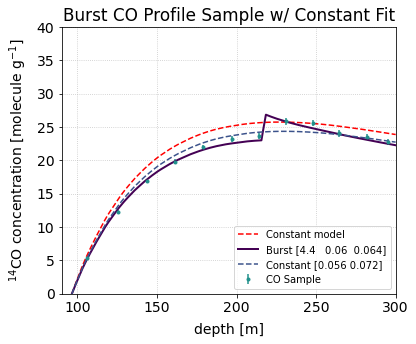

In [191]:
plot_model(3, fit=0)

## Null Hypothesis Bayes Factors

Plots the distribution of the Bayes Factors when sampling from the null (constant) model, calculated in null-generator.py

Also calculates the 3, 4, and 5 sigma threshholds

In [192]:
null_file = 'models/bf_null_20m_{:n}pct_5000000_{:.3f}_{:.3f}_{}_{}_01.npz'.format(relerror*100, fmu_neg, fmu_fast, fixed, f_factors)

if os.path.exists(null_file):
    npzf = np.load(null_file)
    BF_lin_null = npzf['BF_lin']
    BF_step_null = npzf['BF_step']
    BF_100yr_null = npzf['BF_100yr']
    BF_null = [BF_lin_null, BF_step_null, BF_100yr_null]
else:
    print('Null data path does not exist')

[6748  157    0]
[[2.73350537e+00 7.09966037e-01 8.36427734e-02]
 [1.11958410e+00 1.82479563e-01 1.41930999e-02]
 [9.51762001e-02 4.28450409e-03 8.37453678e-05]]


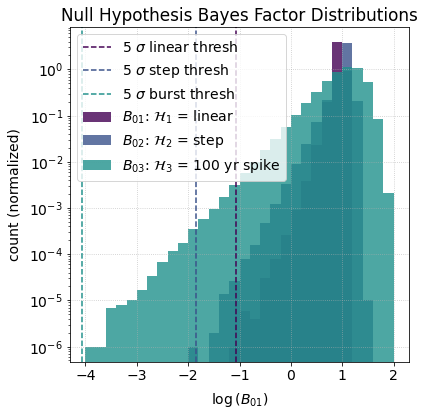

In [193]:
N = len(BF_lin_null)

sigs = [3,4,5]

i = np.array([np.maximum(int(norm.sf(x)*N)-1,0) for x in sigs])
print(i)

sig_thr = np.array([np.sort(nulls)[i] for nulls in BF_null])
print(sig_thr)

BFlim = (-20,50)

logBmin = np.maximum(np.round(np.log10(np.min(np.minimum(np.minimum(BF_lin_null, BF_100yr_null), BF_step_null)))),BFlim[0])
logBmax = np.minimum(np.round(np.log10(np.max(np.maximum(np.maximum(BF_lin_null, BF_100yr_null), BF_step_null)))),BFlim[1])
nbins = int(np.round((logBmax - logBmin) / 0.2) + 1)

fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.hist(np.log10(BF_lin_null), bins=np.linspace(logBmin, logBmax, nbins), alpha=0.8, density=1,
        label=r'$B_{01}$: $\mathcal{H}_1$ = linear');
ax.hist(np.log10(BF_step_null), bins=np.linspace(logBmin, logBmax, nbins), alpha=0.8, density=1,
        label=r'$B_{02}$: $\mathcal{H}_2$ = step');
ax.hist(np.log10(BF_100yr_null), bins=np.linspace(logBmin, logBmax, nbins), alpha=0.8, density=1,
        label=r'$B_{03}$: $\mathcal{H}_3$ = 100 yr spike');
ax.axvline(np.log10(sig_thr[0,2]), ls = '--', c=colors[0], label=r'5 $\sigma$ linear thresh')
ax.axvline(np.log10(sig_thr[1,2]), ls = '--', c=colors[1], label=r'5 $\sigma$ step thresh')
ax.axvline(np.log10(sig_thr[2,2]), ls = '--', c=colors[2], label=r'5 $\sigma$ burst thresh')
ax.set(xlabel=r'$\log{(B_{01})}$',
       ylabel='count (normalized)',
       yscale='log')

ax.legend(loc='best')
plt.title('Null Hypothesis Bayes Factor Distributions')

fig.tight_layout()

Text(0.5, 1.0, 'Null Hypothesis Bayes Factor Distributions')

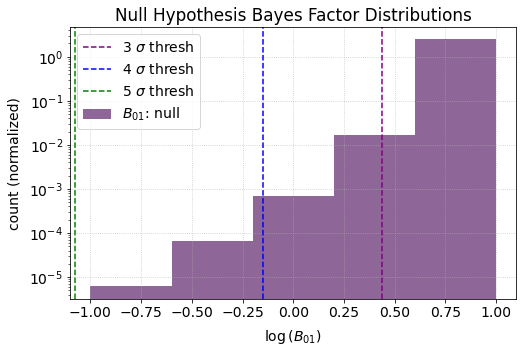

In [194]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

logBmin = np.round(np.log10(np.min(BF_null[0])))
logBmax = np.round(np.log10(np.max(BF_null[0])))
nbins = int(np.round((logBmax - logBmin) / 0.4) + 1)

ax.hist(np.log10(BF_null[0]), bins=np.linspace(logBmin, logBmax, nbins), alpha=0.6, density=1,
        label=r'$B_{01}$: null');
ax.axvline(np.log10(sig_thr[0][0]), ls = '--', c='purple', label=r'3 $\sigma$ thresh')
ax.axvline(np.log10(sig_thr[0][1]), ls = '--', c='blue', label=r'4 $\sigma$ thresh')
ax.axvline(np.log10(sig_thr[0][2]), ls = '--', c='green', label=r'5 $\sigma$ thresh')
ax.set(xlabel=r'$\log{(B_{01})}$',
        ylabel='count (normalized)',
        yscale='log'
        )

ax.legend(loc='best')
plt.title('Null Hypothesis Bayes Factor Distributions')

## Sensitivity Calculations

Finds the smallest amplitude Variable Model Profile such that 50% of the samples result in Bayes factors below the given X sigma threshhold from the Null hypothesis.

In [201]:
def auto_search(m, up=True, sigs = 3):
    # Searches for the smallest amplitude of the variable model such that 50% of trials give a Bayes factor below the
    # null model's X sigma threshold.
    
    """
    Parameters
    -----------
    m : int
        id of the variable model
        1: Linear
        2: Step
        3: Burst
    up : bool
        Tag to search above or below baseline
        True: amp >= 1.0
        False: amp <= 1.0
    sigs : int
        Sigma threshhold of search
        Must be 3, 4, or 5
    """
    # establish cost function, preferring amplitudes closer to 1.0
    cost = []
    s = 1 if up else -1
    for i,p in enumerate(Models[m].parameters):
        c = s*p[0]
        if c>=s:
            if len(p)==1:
                cost.append((i,c))
            elif p[1] == fmu_neg and p[2] == fmu_fast:
                cost.append((i,c))
                
    # sort models by increasing cost
    a = np.array(cost, dtype = [('index', int), ('cost', float)])
    domain = np.sort(a, order='cost')['index']
    
    # search for sensitivity over given domain of models
    j = sens_search(m, domain, sigs)
    
    params = Models[m].parameters[j] # paramters of results
    thresholds(m, params) # plot results
    print('{} Sigma Amplitude Sensitivity: {}'.format(sigs, params[0])) # print results
    return

In [202]:
def sens_search(m, domain = [], sigs = 3):
    # domain should be an array of model indices sorted in ascending order of parameter cost
    
    models = Models[m].models
    
    # run 10 trials for each model; keep models with 1-9 successes
    s = np.array([sens_test(models[i], m, 10)[sigs-3] for i in domain])
    passed = np.abs(s-5)<=4
    if np.any(passed):
        options = np.arange(len(domain))[passed]
        
        # run 50 trials for each remaining model; keep models with 10-40 successes
        s = np.array([sens_test(models[domain[i]], m, 50)[sigs-3] for i in options])
        passed = np.abs(s-25)<=15
        if np.any(passed):
            options = options[passed]
            
            # run 200 trials for each remaining model; keep models with at least 90 successes
            s = np.array([sens_test(models[domain[i]], m, 200)[sigs-3] for i in options])
            passed = s>=90
            if np.any(passed):
                options = options[passed]
                j = options[0] # best option so far
            else:
                j = options[np.argmin(np.abs(s-100))]
        else:
            j = options[np.argmin(np.abs(s-25))]
    else:
        j = options[np.argmin(np.abs(s-5))]
    
    # begin recursive test starting at lowest available option
    thresh = step(j, m, domain, sigs)
    if thresh == -1:
        print('Sensitivity too high to detect')
        return
    else:
        return domain[thresh]

In [203]:
def step(j, m, domain, sigs):
    # Search in the area of model #j
    
    models = Models[m].models
    
    if j>0: # test if it could be lower
        s = sens_test(models[domain[j-1]], m, 1000)[sigs-3]
        if s>= 500: # if it could be lower, step down
            return step(j-1, m, domain, sigs)
        
    s = sens_test(models[domain[j]], m, 1000)[sigs-3]
    if s<500: # test if it's valid
        if j+1 >= len(domain): # if it's not valid and you can't go higher, search fails
            return -1
        else:
            return step(j+1, m, domain, sigs) # if it's not valid, step up
    # make sure it's valid
    #s = sens_test_show(models[domain[j]], m, 10000)[sigs-3]
    #print(s)
    #if s<5000:
        #if j+1 >= len(domain):
            #return -1
        #else:
            #return step(j+1, m, domain, sigs)
    return j # if it's valid and can't be lower, end

In [204]:
def sens_test(model, m, nMC):
    bf_th = np.zeros(3, dtype=float)
    BF_store = np.zeros(nMC, dtype=float)
    N = len(BF_lin_null)

    for i in range(nMC):
        z_samp, CO_samp, dCO_samp = model.sample_z()
        B = const_models.likelihood(z_samp, CO_samp, dCO_samp) / Models[m].likelihood(z_samp, CO_samp, dCO_samp)
        BF_store[i] = B
        
        bf_th += (B <= sig_thr[m-1])
        
    return bf_th

In [205]:
def sens_test_show(model, m, nMC):
    bf_th = np.zeros(3, dtype=float)
    BF_store = np.zeros(nMC, dtype=float)
    N = len(BF_lin_null)

    for i in tqdm(range(nMC)):
        z_samp, CO_samp, dCO_samp = model.sample_z()
        B = const_models.likelihood(z_samp, CO_samp, dCO_samp) / Models[m].likelihood(z_samp, CO_samp, dCO_samp)
        BF_store[i] = B
        
        bf_th += (B <= sig_thr[m-1])
        
    return bf_th

In [206]:
def thresholds(m, theta0, nMC = 10000):
    dist = param_dist(Models[m], theta0)
    j = dist.argmin()
    model = Models[m].models[j]

    # model = COProfile('check_linear_1.14.txt')
    # model = COProfile('co14_linear1.15.txt')
    bf_th = np.zeros(3, dtype=float)
    BF_store = np.zeros(nMC, dtype=float)
    N = len(BF_lin_null)

    for i in tqdm(range(nMC)):
        z_samp, CO_samp, dCO_samp = model.sample_z()
        B = const_models.likelihood(z_samp, CO_samp, dCO_samp) / Models[m].likelihood(z_samp, CO_samp, dCO_samp)
        BF_store[i] = B
        
        bf_th += (B <= sig_thr[m-1])

        # p-value is the tail of the null distribution BF_lin that is
        # less then or equal to the current Bayes Factor.
        # If the distributions don't overlap, then set p=1/N as a lower bound.
        #p = np.maximum(np.sum(BF_null[m-1] <= B) / N, 1./N)
        #sigma = norm.isf(p)

        #print(np.log10(B), p, sigma, sigma>np.asarray([3,4,5]))
        #for j, sig_thr in enumerate([3.,4.,5.]):
            #if sigma >= sig_thr:
                #bf_th[j] += 1

    print(bf_th / nMC)
    
    fig, ax = plt.subplots(1,1, figsize=(8,5))

    logBmin = np.round(np.log10(np.minimum(np.min(BF_null[m-1]), np.min(BF_store))))
    logBmax = np.round(np.log10(np.maximum(np.max(BF_null[m-1]), np.max(BF_store))))
    nbins = int(np.round((logBmax - logBmin) / 0.4) + 1)

    ax.hist(np.log10(BF_null[m-1]), bins=np.linspace(logBmin, logBmax, nbins), alpha=0.8, density=1,
            label=r'$B_{01}$: null'+' ({:.3f}, {:.3f})'.format(fmu_neg, fmu_fast));
    ax.hist(np.log10(BF_store), bins=np.linspace(logBmin, logBmax, nbins), alpha=0.8, density=1,
            label=r'$B_{01}$: '+modelNames[m]+' {}'.format(Models[m].parameters[j,0]));
    ax.axvline(np.log10(sig_thr[m-1][0]), ls = '--', c='purple', label=r'3 $\sigma$ thresh')
    ax.axvline(np.log10(sig_thr[m-1][1]), ls = '--', c='blue', label=r'4 $\sigma$ thresh')
    ax.axvline(np.log10(sig_thr[m-1][2]), ls = '--', c='green', label=r'5 $\sigma$ thresh')
    ax.set(xlabel=r'$\log{(B_{01})}$',
           ylabel='count (normalized)',
           yscale='log'
          )
    plt.title('{} vs Constant Bayes Factor Distributions'.format(modelNames[m].title()))

    ax.legend(loc='best')
    
    return bf_th/nMC

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:13<00:00, 731.42it/s]


[0.6075 0.3116 0.089 ]
3 Sigma Amplitude Sensitivity: 1.06


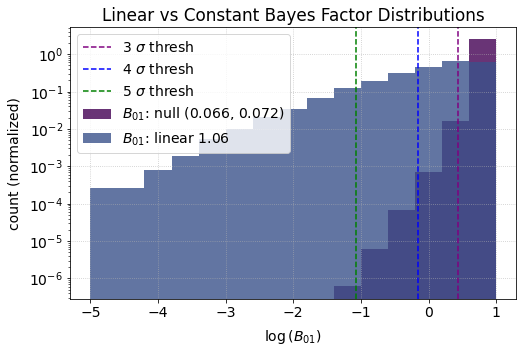

In [209]:
auto_search(1, True, 3)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:13<00:00, 744.71it/s]


[0.9619 0.8487 0.5783]
5 Sigma Amplitude Sensitivity: 1.08


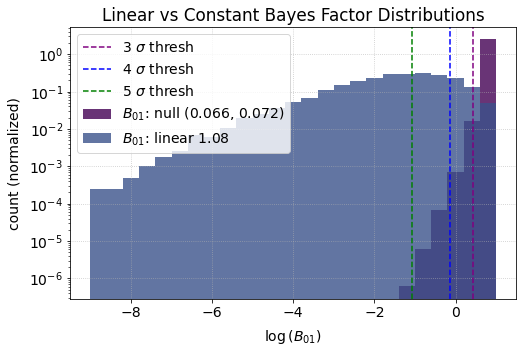

In [208]:
auto_search(1, True, 5)

## CO Profile Generation

Using the profiles generated by Deep_Ice_14CO_age_delta_neg.m and Deep_Ice_14CO_age_delta_fast.m, we can calculate the 14CO distributions resulting from each unit step of the time dependence of f_neg and f_fast.

In this way, we can quickly generate custom CO Profiles without having to run new matlab code.

In [195]:
def plot_factors(t, neg, fast, slopes, name, lims=(0.02, 0.12), sample=True):
    if len(np.shape(neg))==1:
        neg = np.array([neg])
    if len(np.shape(fast))==1:
        fast = np.array([fast])
    
    fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
    for i,n in enumerate(neg):
        ax.plot(t, n, label='{} {:.2f}'.format(name, slopes[i]+1))
    ax.axhline(fmu_neg, ls='--', lw=2, c='red', label='Const')
    ax.set(xlim=(min(t),max(t)),
           xlabel='time [yrs]',
            ylim=lims,
            ylabel='f_mu_neg')
    ax.legend(loc='lower left', fontsize=10)
    plt.title('{} Model f_neg'.format(name))
    
    fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
    for i,f in enumerate(fast):
        ax.plot(t, f, label='{} {:.2f}'.format(name, slopes[i]+1))
    ax.axhline(fmu_fast, ls='--', lw=2, c='red', label='Const')
    ax.set(xlim=(min(t),max(t)),
            xlabel='time [yrs]',
            ylim=lims,
            ylabel='f_mu_fast')
    ax.legend(loc='lower left', fontsize=10)
    plt.title('{} Model f_fast'.format(name))

In [196]:
def plot_profiles(profiles, slopes, name, sample=False):
    if len(np.shape(np.array(profiles))) == 0:
        p = np.array([profiles])
    else:
        p = np.array(profiles)
    

    fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
    for i,profile in enumerate(p):
        ax.plot(profile.z, profile.CO, label='{} {:.2f}'.format(name, slopes[i]+1))
    ax.plot(const_profile.z, const_profile.CO, ls='--', lw=2, c='red', label='Const')
    if sample:
        z_samp, CO_samp, dCO_samp = p[0].sample_z()
        ax.errorbar(z_samp, CO_samp, yerr=dCO_samp, fmt='.')
    ax.set(xlim=(90,300),
            xlabel='depth [m]',
            ylim=(0,40),
            ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
    ax.legend(loc='upper left', fontsize=10)
    plt.title('{} Model CO Profiles'.format(name))

In [197]:
generator = COGenerator('models/balco_14co_delta_neg_models.fits', 'models/balco_14co_delta_fast_models.fits')

In [198]:
const_profile = generator.generate()

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.00it/s]


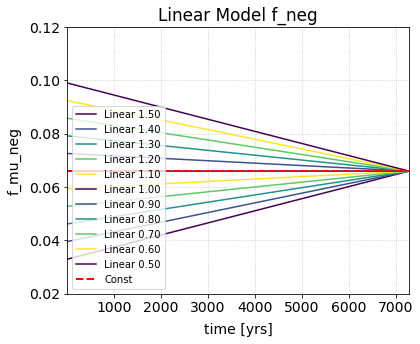

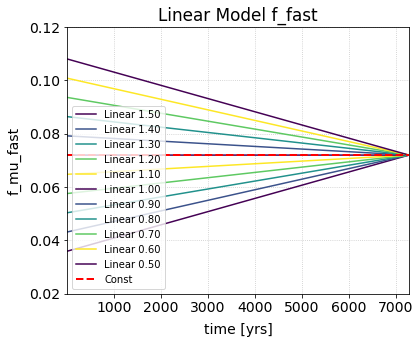

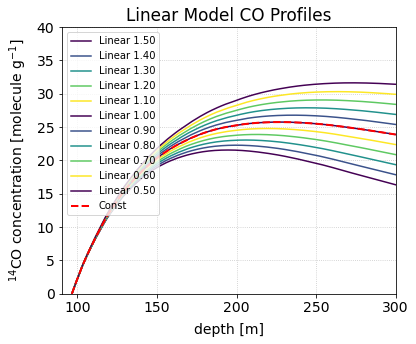

In [199]:
t = generator.t
tmax = np.max(t)
tmid = int(tmax/2)
tmin = np.min(t)

#t_scale = t/(tmax-tmin) # fixed in past ( t from 0 to 1 )
t_scale = (t-tmax)/(tmax-tmin) # fixed in present ( t from -1 to 0 )

# linear
slopes = np.arange(0.5, -0.6, -0.1)
amp = 1 + np.expand_dims(slopes, axis=1) * t_scale # linear
name = 'Linear'
lims = (0.02, 0.12)

# step
#slopes = np.arange(0.5, -0.6, -0.1)
#amp = 1 + np.expand_dims(slopes, axis=1) * np.heaviside(abs(t_scale) - 0.5, 1)
#name = 'Step'
#lims = (0.02, 0.12)

# burst
#slopes = np.arange(9., -1., -1.)
#amp = np.ones((len(slopes),len(t)))
#amp[:,3000:3100] += np.expand_dims(slopes,axis=1)
#name = 'Burst'
#lims = (0., 0.8)

neg = fmu_neg * amp
fast = fmu_fast * amp

linear_profiles = []
for i in tqdm(range(len(slopes))):
    linear_profiles.append(generator.generate(neg[i], fast[i]))
plot_factors(t, neg, fast, slopes, name, lims)
    
linear_profiles = np.array(linear_profiles)

plot_profiles(linear_profiles, slopes, name)